# Set UP 

In [55]:
import os, gc 

import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

from sklearn import preprocessing
from imutils import face_utils 
import argparse 
import dlib
import cv2
import imutils
from PIL import Image 

from utils import * 

## Building Masks

In [10]:
from tqdm.notebook import tqdm 

path_to_gen_mask = []

for index in tqdm(data.index) : 
    name = data.iloc[index]['name']
    image_path = data.iloc[index].path_to_unmasked_face
    unmasked =  cv2.imread(image_path)
    gray = cv2.cvtColor(unmasked, cv2.COLOR_BGR2GRAY)
    rect = detector(gray, 1)[0]
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    shape = keep_it(shape)
    image_shape = gray.shape
    polygon = shape
    mask1 = get_mask_from_polygon_mpl(image_shape, polygon).astype('uint')
    save_path = path +  name + '/' +  image_path.split('/')[-1][:-4] 
    np.save(save_path , mask1)
    path_to_gen_mask.append(save_path)
data['path_to_gen_mask'] = path_to_gen_mask

# Verify Dataset

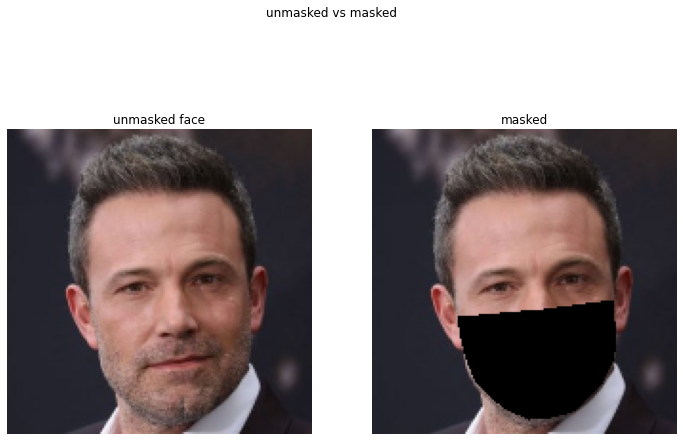

In [11]:
unmasked_path = data.iloc[25]['path_to_unmasked_face']
masked_path   = data.iloc[25]['path_to_gen_mask']
masked   = np.load(masked_path + '.npy')
unmasked = plt.imread(unmasked_path)
masked = unmasked * (1-masked[:,:,np.newaxis])
plot_unmasked_and_masked(unmasked , masked )


# Data Preparation for face recognation 

In [15]:
path  = 'dataset/celeb_faces_data/'
train_path = path + 'train.csv'
valid_path = path + 'valid.csv'
train = pd.DataFrame()
val = pd.DataFrame()

In [17]:
all_paths = [] 
im_class  = [] 

for name in os.listdir(path + 'train/') : 
    for im_path in os.listdir(path + 'train/' + name + '/') : 
        if im_path[-3:] == 'jpg' : 
            final_path = path + 'train/' + name + '/' + im_path
            all_paths.append(final_path)
            im_class.append(name)
            
train['name'] = im_class
train['unmasked_path'] = all_paths
train.head()

,name,unmasked_path
0,mindy_kaling,dataset/celeb_faces_data/train/mindy_kaling/ht...
1,mindy_kaling,dataset/celeb_faces_data/train/mindy_kaling/ht...
2,mindy_kaling,dataset/celeb_faces_data/train/mindy_kaling/ht...
3,mindy_kaling,dataset/celeb_faces_data/train/mindy_kaling/ht...
4,mindy_kaling,dataset/celeb_faces_data/train/mindy_kaling/ht...


In [19]:
all_paths = [] 
im_class  = [] 

for name in os.listdir(path + 'val/') : 
    for im_path in os.listdir(path + 'val/' + name + '/') : 
        if im_path[-3:] == 'jpg' : 
            final_path = path + 'val/' + name + '/' + im_path
            all_paths.append(final_path)
            im_class.append(name)
            
val['name'] = im_class
val['unmasked_path'] = all_paths
val.head()

,name,unmasked_path
0,mindy_kaling,dataset/celeb_faces_data/val/mindy_kaling/http...
1,mindy_kaling,dataset/celeb_faces_data/val/mindy_kaling/http...
2,mindy_kaling,dataset/celeb_faces_data/val/mindy_kaling/http...
3,mindy_kaling,dataset/celeb_faces_data/val/mindy_kaling/http...
4,mindy_kaling,dataset/celeb_faces_data/val/mindy_kaling/http...


In [22]:
le = preprocessing.LabelEncoder()
le.fit(train.name.values.reshape(-1,1))
train['class'] = le.transform(train.name.values.reshape(-1,1)) 
val['class'] = le.transform(val.name.values.reshape(-1,1)) 

/home/naim/anaconda3/envs/Naim/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [24]:
train['class'].nunique()

5

In [25]:
val['class'].nunique()

5

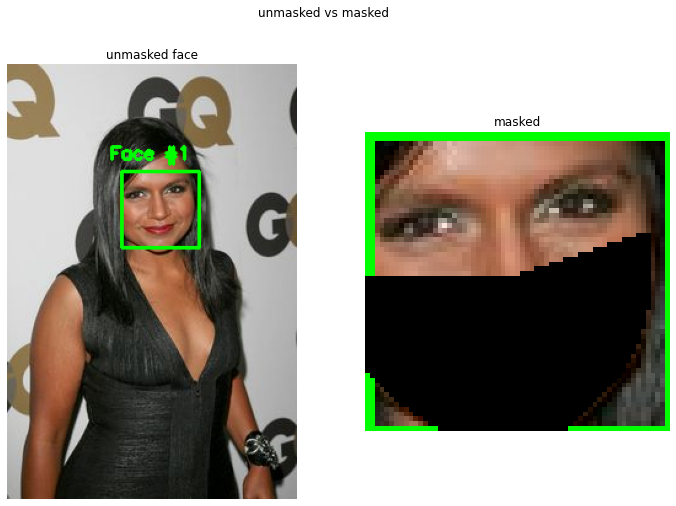

In [51]:
unmasked_path = train['unmasked_path'].iloc[0]

unmasked =  cv2.imread(unmasked_path)
gray = cv2.cvtColor(unmasked, cv2.COLOR_BGR2GRAY)
rect = detector(gray, 1)[0]
(x, y, w, h) = face_utils.rect_to_bb(rect)
cv2.rectangle(unmasked, (x, y), (x + w, y + h), (0, 255, 0), 2)
# show the face number
cv2.putText(unmasked, "Face #{}".format(0 + 1), (x - 10, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

unmasked = cv2.cvtColor(unmasked, cv2.COLOR_BGR2RGB)
shape = predictor(gray, rect)
shape = face_utils.shape_to_np(shape)
shape = keep_it(shape)
image_shape = gray.shape
polygon = shape
mask1 = get_mask_from_polygon_mpl(image_shape, polygon).astype('uint')

masked_image = unmasked * (1-mask1[:,:,np.newaxis])
masked_image = masked_image[y:y + h , x:x + w]

plot_unmasked_and_masked( unmasked , masked_image)

In [52]:
path_to_cropped_image = []
path_to_masked_image = []

for index in tqdm(train.index) : 
    name = train.iloc[index]['name']
    image_path = train.iloc[index].unmasked_path
    unmasked =  cv2.imread(image_path)
    gray = cv2.cvtColor(unmasked, cv2.COLOR_BGR2GRAY)
    try : 
        rect = detector(gray, 1)[0]
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        shape = keep_it(shape)
        image_shape = gray.shape
        polygon = shape
        mask1 = get_mask_from_polygon_mpl(image_shape, polygon).astype('uint')
        masked =  unmasked * (1-mask1[:,:,np.newaxis])
        cropped_image = unmasked[y:y + h , x:x + w]
        masked_image =  masked[y:y + h , x:x + w]
        save_path = '/'.join(image_path.split('/')[:-1]) + '/' +  'cropped_' + image_path.split('/')[-1]
        path_to_cropped_image.append(save_path)
        cv2.imwrite(save_path, cropped_image)
        save_path = '/'.join(image_path.split('/')[:-1]) + '/' +  'masked_' + image_path.split('/')[-1]
        path_to_masked_image.append(save_path)
        cv2.imwrite(save_path, masked_image)
    except : 
        print('error') 
        path_to_cropped_image.append('Nan')
        path_to_masked_image.append('Nan')
        
train['path_to_cropped_image'] = path_to_cropped_image
train['path_to_masked_image']  = path_to_masked_image

error
error
error
error
error



In [53]:
path_to_cropped_image = []
path_to_masked_image = []

for index in tqdm(val.index) : 
    name = val.iloc[index]['name']
    image_path = val.iloc[index].unmasked_path
    unmasked =  cv2.imread(image_path)
    gray = cv2.cvtColor(unmasked, cv2.COLOR_BGR2GRAY)
    try : 
        rect = detector(gray, 1)[0]
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        shape = keep_it(shape)
        image_shape = gray.shape
        polygon = shape
        mask1 = get_mask_from_polygon_mpl(image_shape, polygon).astype('uint')
        masked =  unmasked * (1-mask1[:,:,np.newaxis])
        cropped_image = unmasked[y:y + h , x:x + w]
        masked_image =  masked[y:y + h , x:x + w]
        save_path = '/'.join(image_path.split('/')[:-1]) + '/' +  'cropped_' + image_path.split('/')[-1]
        path_to_cropped_image.append(save_path)
        cv2.imwrite(save_path, cropped_image)
        save_path = '/'.join(image_path.split('/')[:-1]) + '/' +  'masked_' + image_path.split('/')[-1]
        path_to_masked_image.append(save_path)
        cv2.imwrite(save_path, masked_image)
    except : 
        print('error') 
        path_to_cropped_image.append('Nan')
        path_to_masked_image.append('Nan')
        
val['path_to_cropped_image'] = path_to_cropped_image
val['path_to_masked_image']  = path_to_masked_image

error



In [71]:
x = train[train['path_to_masked_image'] == 'Nan'].index

In [72]:
train.drop(x ,inplace =True)

In [74]:
val.to_csv(valid_path)
train.to_csv(train_path)

In [82]:
val

,name,unmasked_path,class,path_to_cropped_im,path_to_cropped_image,path_to_masked_image
0,mindy_kaling,dataset/celeb_faces_data/val/mindy_kaling/http...,4,dataset/celeb_faces_data/val/mindy_kaling/crop...,dataset/celeb_faces_data/val/mindy_kaling/crop...,dataset/celeb_faces_data/val/mindy_kaling/mask...
1,mindy_kaling,dataset/celeb_faces_data/val/mindy_kaling/http...,4,dataset/celeb_faces_data/val/mindy_kaling/crop...,dataset/celeb_faces_data/val/mindy_kaling/crop...,dataset/celeb_faces_data/val/mindy_kaling/mask...
2,mindy_kaling,dataset/celeb_faces_data/val/mindy_kaling/http...,4,dataset/celeb_faces_data/val/mindy_kaling/crop...,dataset/celeb_faces_data/val/mindy_kaling/crop...,dataset/celeb_faces_data/val/mindy_kaling/mask...
3,mindy_kaling,dataset/celeb_faces_data/val/mindy_kaling/http...,4,dataset/celeb_faces_data/val/mindy_kaling/crop...,dataset/celeb_faces_data/val/mindy_kaling/crop...,dataset/celeb_faces_data/val/mindy_kaling/mask...
4,mindy_kaling,dataset/celeb_faces_data/val/mindy_kaling/http...,4,dataset/celeb_faces_data/val/mindy_kaling/crop...,dataset/celeb_faces_data/val/mindy_kaling/crop...,dataset/celeb_faces_data/val/mindy_kaling/mask...
5,elton_john,dataset/celeb_faces_data/val/elton_john/httpcd...,1,dataset/celeb_faces_data/val/elton_john/croppe...,dataset/celeb_faces_data/val/elton_john/croppe...,dataset/celeb_faces_data/val/elton_john/masked...
6,elton_john,dataset/celeb_faces_data/val/elton_john/httpcd...,1,dataset/celeb_faces_data/val/elton_john/croppe...,dataset/celeb_faces_data/val/elton_john/croppe...,dataset/celeb_faces_data/val/elton_john/masked...
7,elton_john,dataset/celeb_faces_data/val/elton_john/httpcd...,1,dataset/celeb_faces_data/val/elton_john/croppe...,dataset/celeb_faces_data/val/elton_john/croppe...,dataset/celeb_faces_data/val/elton_john/masked...
8,elton_john,dataset/celeb_faces_data/val/elton_john/httpaf...,1,dataset/celeb_faces_data/val/elton_john/croppe...,dataset/celeb_faces_data/val/elton_john/croppe...,dataset/celeb_faces_data/val/elton_john/masked...
9,elton_john,dataset/celeb_faces_data/val/elton_john/httpcd...,1,dataset/celeb_faces_data/val/elton_john/croppe...,dataset/celeb_faces_data/val/elton_john/croppe...,dataset/celeb_faces_data/val/elton_john/masked...
